Ingesting the data & data checks

In [83]:
import pandas as pd

The first data set comes from the FEMA National Risk Index, which defines risk as the potential for negative impacts as a result of 18 natural hazards (earthquake, flood, winter weather, hail, etc). The risk equation behind the Risk Index includes three components: a natural hazards component (Expected Annual Loss), a consequence enhancing component (Social Vulnerability), and a consequence reduction component (Community Resilience). The dataset supporting the natural hazards component provides estimates measured in 2022 U.S. dollars. 

For this project, I am only extracting the column "Expected Annual Loss Rate - Building". This rate is designed to reflect the average expected annual percentage loss for the building value within each county, controlled for community size. EAL Rate metrics are calculated as decimals but can be understood as the fraction of a value (whether buildings, people, or agriculture) that could be expected to be lost annually on average. For example, a building EAL Rate of 0.00013 is equivalent to an expectation of $1 out of every $7.7K of building value lost to natural hazards annually on average.


In [84]:
# Import fema risk index data
data = pd.read_csv('NRI_Table_Counties.csv')

# Keep Expected Annual Loss Rate - Building for Each Hazard
keep_cols = ["STATEABBRV", "STATEFIPS", "COUNTYFIPS", 'STCOFIPS', 'POPULATION','BUILDVALUE','AREA']

alrb_cols = [col for col in data.columns if "_ALRB" in col]

df = data[keep_cols + alrb_cols]

num_rows, num_cols = df.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

print(df.head(5))

Number of rows: 3231
Number of columns: 24
  STATEABBRV  STATEFIPS  COUNTYFIPS  STCOFIPS  POPULATION    BUILDVALUE  \
0         AL          1           1      1001       58764  9.123274e+09   
1         AL          1           3      1003      231365  4.596848e+10   
2         AL          1           5      1005       25160  4.847697e+09   
3         AL          1           7      1007       22239  3.146947e+09   
4         AL          1           9      1009       58992  7.815620e+09   

          AREA  AVLN_ALRB  CFLD_ALRB  CWAV_ALRB  ...     ISTM_ALRB  \
0   610.470508        NaN        NaN        0.0  ...  2.326986e-07   
1  2047.738775        NaN   0.000003        0.0  ...  5.592036e-09   
2   913.646511        NaN        NaN        0.0  ...  2.506872e-07   
3   632.486798        NaN        NaN        0.0  ...  1.061468e-05   
4   657.196555        NaN        NaN        0.0  ...  1.019435e-05   

      LNDS_ALRB     LTNG_ALRB  RFLD_ALRB  SWND_ALRB  TRND_ALRB  TSUN_ALRB  \
0  4.932

The second data set comes from the U.S. Census American Community Survey 2021 5-Year Estimates, which provides demographic data for each county in the US. 
The features were selected to capture specifically housing vulnerability, with new variables that are not included in the SVI that is used to calculate FEMA's Risk Index. 

These features are: Median Year Built, % Units Build Pre-1940, % Overcrowded Units, Median Rent as % of Income, % Renters Spending >50% Income on Rent, % Vacant Units, % Renter Occupied Units, % Mobile Homes, % Units Lacking Plumbing, Total Housing Units

In [85]:
#import census data & create housing features

from census import Census

API_KEY = "a25a6b897f5af035776a6226ae83119d8ca9791b"
c = Census(API_KEY)

variables = {
    "B25035_001E": "median_year_built",
    "B25034_011E": "units_pre1940",
    "B25034_001E": "total_units_pre1940_base",
    "B25014_005E": "renter_over_1_1to1_5",
    "B25014_006E": "renter_over_1_5to2",
    "B25014_007E": "renter_over_2",
    "B25014_011E": "owner_over_1_1to1_5",
    "B25014_012E": "owner_over_1_5to2",
    "B25014_013E": "owner_over_2",
    "B25014_001E": "total_occupied_rooms",
    "B25071_001E": "median_rent_pct_income",
    "B25070_010E": "renters_over_50pct_income",
    "B25070_001E": "total_renters_income_base",
    "B25001_001E": "total_housing_units",
    "B25002_003E": "vacant_units",
    "B25002_001E": "total_units_vacancy_base",
    "B25003_003E": "renter_occupied_units",
    "B25003_001E": "total_occupied_units",
    "B25032_011E": "mobile_homes_owner",
    "B25032_022E": "mobile_homes_renter",
    "B25032_001E": "total_units_mobile_base",
    "B25047_003E": "lacking_plumbing",
    "B25047_001E": "total_units_plumbing_base",
    "B01003_001E": "total_population",
    "B25004_002E" :  "for_rent",
    "B25004_004E" : "for_sale_only",
    "B25004_003E" : "sold_not_occupied",
    "B25004_005E" : "rented_not_occupied"  
}


response = c.acs5.get(
    list(variables.keys()) + ["NAME"],
    {'for': 'county:*', 'in': 'state:*'},
    year=2021
)

housing_data = pd.DataFrame(response)

housing_data = housing_data.rename(columns=variables)

housing_data["state_fips"] = housing_data["state"]
housing_data["county_fips"] = housing_data["county"]
housing_data["fips"] = housing_data["state"] + housing_data["county"]

for col in variables.values():
    housing_data[col] = pd.to_numeric(housing_data[col], errors="coerce")

# % housing units built before 1940
housing_data["pct_units_pre1940"] = (
    housing_data["units_pre1940"] / housing_data["total_units_pre1940_base"] * 100
)

# % occupied housing units that are overcrowded (>1.01 persons per room)
housing_data["overcrowded_total"] = (
    housing_data["renter_over_1_1to1_5"] + housing_data["renter_over_1_5to2"] + housing_data["renter_over_2"] +
    housing_data["owner_over_1_1to1_5"] + housing_data["owner_over_1_5to2"] + housing_data["owner_over_2"]
)
housing_data["pct_overcrowded"] = (
    housing_data["overcrowded_total"] / housing_data["total_occupied_rooms"] * 100
)

# % renters spending >50% income on rent
housing_data["pct_renters_over_50pct_income"] = (
    housing_data["renters_over_50pct_income"] / housing_data["total_renters_income_base"] * 100
)

# % vacant units
housing_data["pct_vacant_units"] = (
    housing_data["vacant_units"] / housing_data["total_units_vacancy_base"] * 100
)

# % renter occupied units of all occupied units
housing_data["pct_renter_occupied"] = (
    housing_data["renter_occupied_units"] / housing_data["total_occupied_units"] * 100
)

# % mobile homes of all housing units
housing_data["mobile_home_units"] = (
    housing_data["mobile_homes_owner"] + housing_data["mobile_homes_renter"]
)
housing_data["pct_mobile_homes"] = (
    housing_data["mobile_home_units"] / housing_data["total_units_mobile_base"] * 100
)

# % housing units lacking plumbing 
housing_data["pct_lacking_plumbing"] = (
    housing_data["lacking_plumbing"] / housing_data["total_units_plumbing_base"] * 100
)

# % available housing
housing_data["for_sale_total"] = (
    housing_data["for_rent"] + housing_data["for_sale_only"] 
)

housing_data["total_housing_base"] = (
    housing_data["for_rent"] + housing_data["for_sale_only"] 
    + housing_data['sold_not_occupied'] + housing_data['rented_not_occupied']
)
housing_data["pct_avail_housing"] = (
    housing_data["for_sale_total"] / housing_data["total_housing_base"] * 100
)


output_columns = [
    "fips", "NAME", "total_population", "median_year_built",
    "pct_units_pre1940", "pct_overcrowded", "median_rent_pct_income",
    "pct_renters_over_50pct_income", "pct_vacant_units",
    "pct_renter_occupied", "pct_mobile_homes", "pct_lacking_plumbing",
      'total_housing_units', "pct_avail_housing"
]
housing = housing_data[output_columns]

num_rows, num_cols = housing.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 3221
Number of columns: 14


In [86]:
# Merge expected loss rates w/ housing census data
housing.loc[:, "fips"] = housing["fips"].astype(str).str.lstrip("0")
df.loc[:, "STCOFIPS"] = df["STCOFIPS"].astype(str).str.lstrip("0")
full_df = df.merge(housing, how="left", left_on="STCOFIPS", right_on="fips")

/var/folders/vd/kxtbrgs50mx5h4q6mzczwdgc0000gn/T/ipykernel_1039/2759558546.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1001' '1003' '1005' ... '78010' '78020' '78030']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, "STCOFIPS"] = df["STCOFIPS"].astype(str).str.lstrip("0")


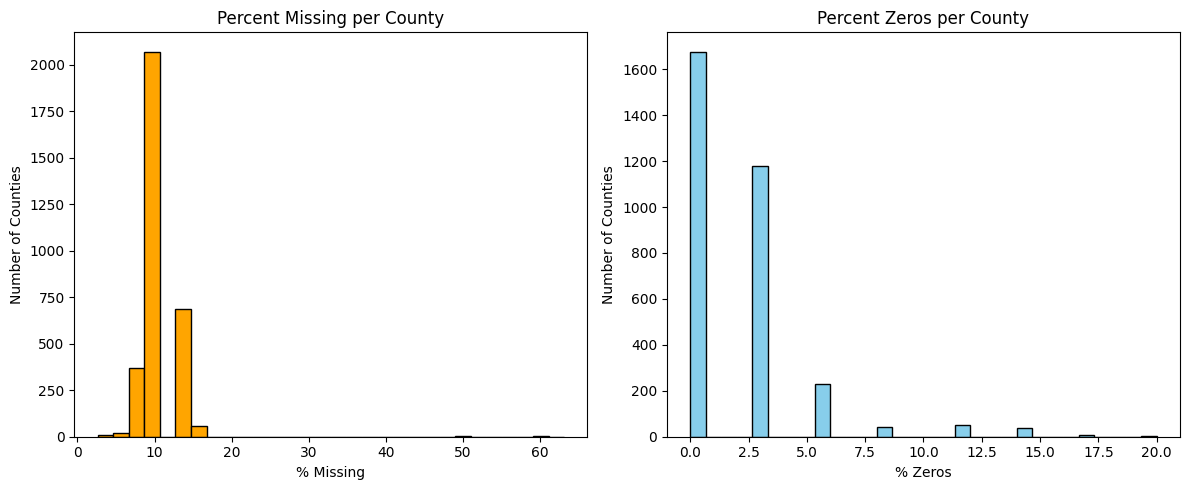

Unique FIPS/counties codes: 3231
Total rows: 3231
Total columns: 40
  STATEABBRV  STATEFIPS  COUNTYFIPS STCOFIPS  POPULATION    BUILDVALUE  \
0         AL          1           1     1001       58764  9.123274e+09   
1         AL          1           3     1003      231365  4.596848e+10   
2         AL          1           5     1005       25160  4.847697e+09   
3         AL          1           7     1007       22239  3.146947e+09   
4         AL          1           9     1009       58992  7.815620e+09   
5         AL          1          11     1011       10326  1.578438e+09   
6         AL          1          13     1013       19015  3.448344e+09   
7         AL          1          15     1015      116250  2.269150e+10   
8         AL          1          17     1017       34738  5.993491e+09   
9         AL          1          19     1019       24933  4.433991e+09   

          AREA  AVLN_ALRB  CFLD_ALRB  CWAV_ALRB  ...  median_rent_pct_income  \
0   610.470508        NaN        NaN 

In [87]:
# Data Checks
import matplotlib.pyplot as plt

# % Missing Values & Zeroes by County

percent_missing = full_df.isnull().mean(axis=1) * 100
full_df["percent_missing"] = percent_missing

numeric_cols = full_df.select_dtypes(include=["number"]).columns
percent_zeros = (full_df[numeric_cols] == 0).mean(axis=1) * 100
full_df["percent_zeros"] = percent_zeros


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(full_df["percent_missing"], bins=30, color='orange', edgecolor='black')
plt.title("Percent Missing per County")
plt.xlabel("% Missing")
plt.ylabel("Number of Counties")

plt.subplot(1, 2, 2)
plt.hist(full_df["percent_zeros"], bins=30, color='skyblue', edgecolor='black')
plt.title("Percent Zeros per County")
plt.xlabel("% Zeros")
plt.ylabel("Number of Counties")

plt.tight_layout()
plt.show()

num_unique_fips = full_df['STCOFIPS'].nunique()
num_rows = full_df.shape[0]
num_cols = full_df.shape[1]

print(f"Unique FIPS/counties codes: {num_unique_fips}")
print(f"Total rows: {num_rows}")
print(f"Total columns: {num_cols}")

print(full_df.head(10))

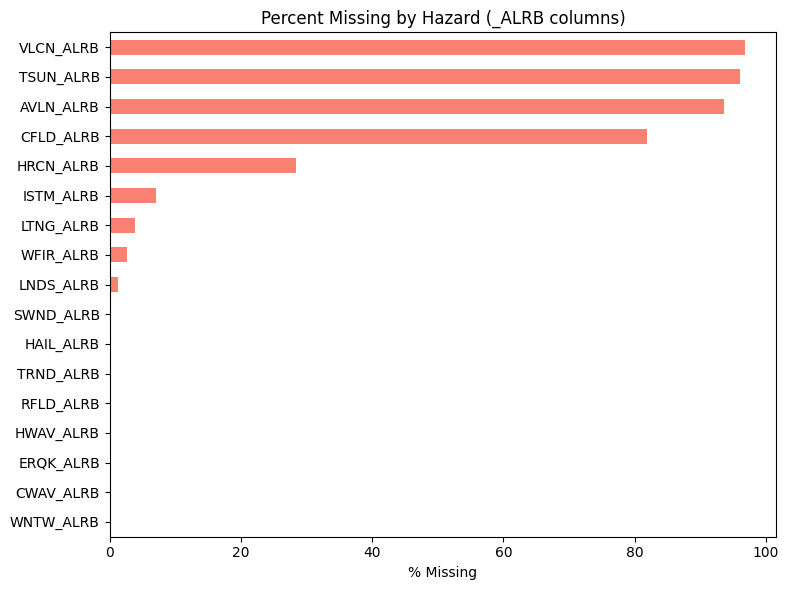

In [88]:
# Missing data by Hazard
hazard_cols = [col for col in full_df.columns if col.endswith("_ALRB")]
missing = full_df[hazard_cols].isnull().mean() * 100
missing.sort_values().plot(kind='barh', figsize=(8, 6), color='salmon')
plt.title("Percent Missing by Hazard (_ALRB columns)")
plt.xlabel("% Missing")
plt.tight_layout()
plt.show()

(full_df.isnull().mean() * 100).sort_values(ascending=False).head(10)

hazard_cols = [col for col in full_df.columns if '_ALRB' in col]
full_df[hazard_cols] = full_df[hazard_cols].fillna(0)

Counties in which the hazard is (historically) impossible have missing data in that cell. The top five hazards with the greatest % of counties with missing data, where that hazard would theoretically never happen, are volcanic activity, tsunami, avalanche, coastal flooding, hurricane, which makes sense because a large portion of the country doesn't have volcanoes, snow covered mountains, and is not by the coast. We are going to put 0 here because it represents zero expected annual loss in these counties. It also appears that generally, most demographic/housing variables do not have a lot of missing data, as the demographic feature with the highest % of missing data is pct_avail_housing which is missing 0.74% of its data. 

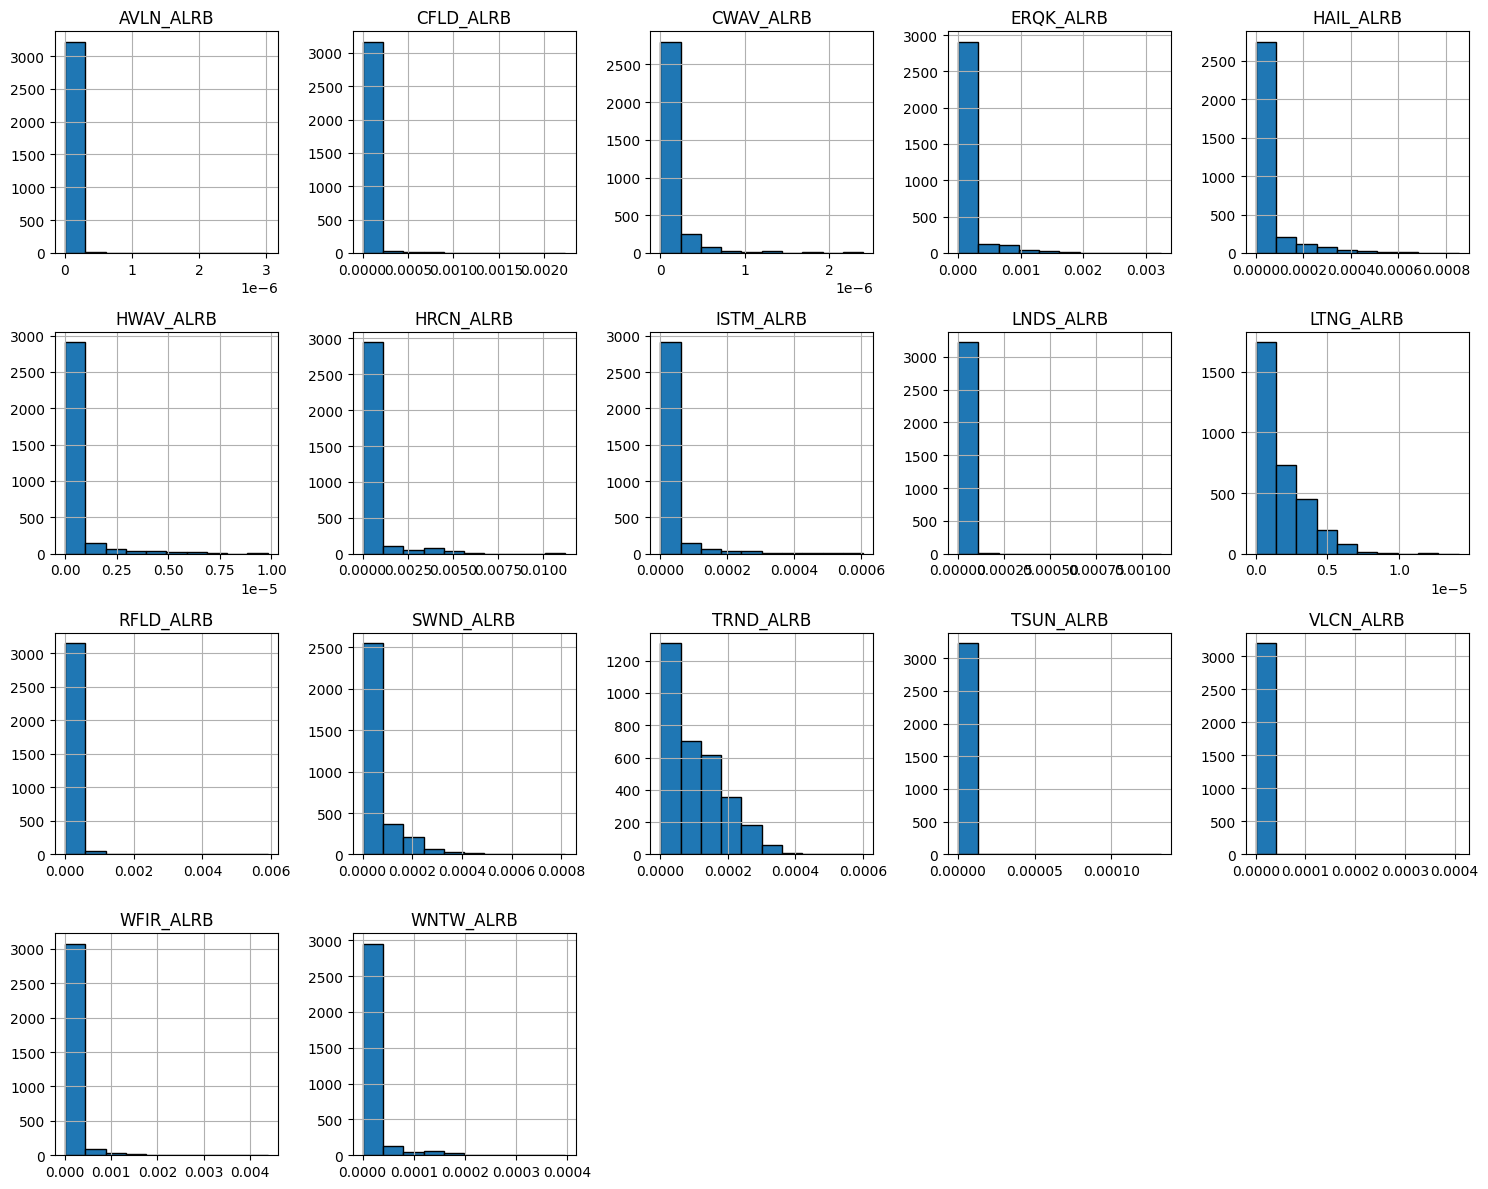

In [89]:
# Check distribution of EAL by Hazard + log transform columns
import numpy as np

alrb_columns = [col for col in full_df.columns if '_ALRB' in col]

n_cols = 5  
n_rows = int(np.ceil(len(alrb_columns) / n_cols))  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()

for i, col in enumerate(alrb_columns):
    axes[i].hist(full_df[col].dropna(), bins=10, edgecolor='black')   
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

df_log = full_df[alrb_columns].apply(lambda x: np.log(x + 1))  

full_df[alrb_columns] = df_log

Histograms depict long right tails on all the hazards' expected loss rate distributions, so applying a log transformation will normalize and control the variance. 

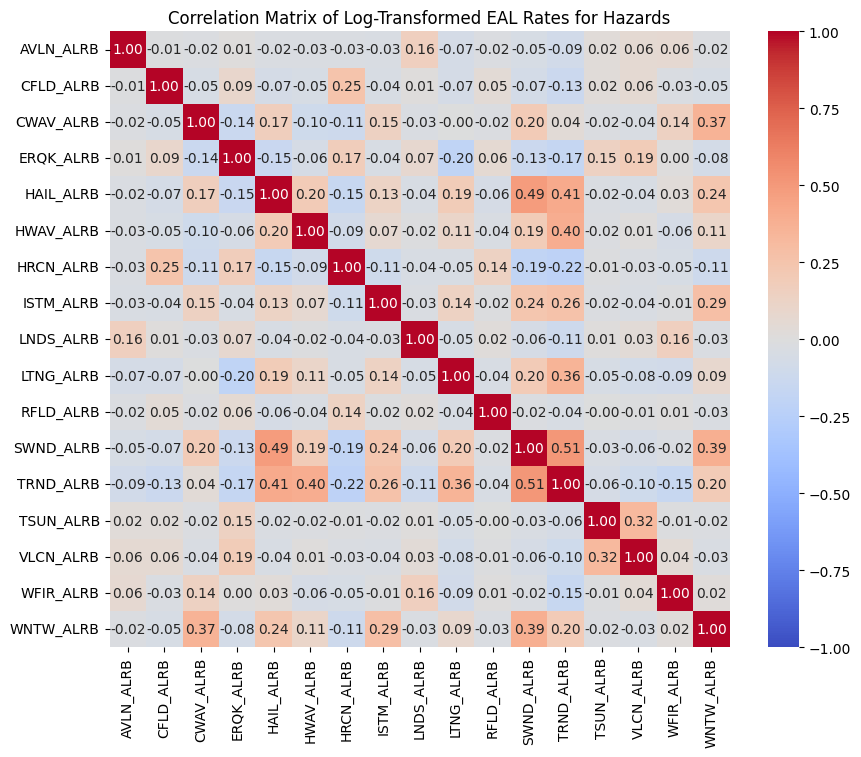

In [90]:
import seaborn as sns
log_corr = df_log.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(log_corr, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Log-Transformed EAL Rates for Hazards')
plt.show()

Correlation matrix does not reveal particular collinearity between EAL Building Rates for the different hazards. 

In [91]:
# Check top 5 counties by population
county_pops = full_df.groupby("NAME")["total_population"].sum()
top5_counties = county_pops.nlargest(5)
print("Top 5 Counties by Population:\n", top5_counties)

Top 5 Counties by Population:
 NAME
Los Angeles County, California    10019635.0
Cook County, Illinois              5265398.0
Harris County, Texas               4697957.0
Maricopa County, Arizona           4367186.0
San Diego County, California       3296317.0
Name: total_population, dtype: float64


In [92]:
# Check for any negative values + change to NA
import numpy as np

numeric_cols = full_df.select_dtypes(include='number')
negative_counts = (numeric_cols < 0).sum()
columns_with_negatives = negative_counts[negative_counts > 0]
print("Columns with negative values:\n", columns_with_negatives)

negatives_bool = full_df.select_dtypes(include='number') < 0
negative_cells = negatives_bool[negatives_bool].stack()
negative_locations = negative_cells.index.tolist()

negatives = full_df.select_dtypes(include='number')[negatives_bool]
negative_entries = negatives[negatives < 0].stack()
negative_entries_df = negative_entries.reset_index()
negative_entries_df.columns = ['RowIndex', 'Column', 'Value']
print(negative_entries_df)

cleaned_df = full_df.copy(deep=True)
numeric_cols = cleaned_df.select_dtypes(include='number').columns
cleaned_df[numeric_cols] = cleaned_df[numeric_cols].mask(cleaned_df[numeric_cols] < 0, np.nan)

numeric_cols = cleaned_df.select_dtypes(include='number')
negative_counts = (numeric_cols < 0).sum()
columns_with_negatives = negative_counts[negative_counts > 0]
print("Columns with negative values:\n", columns_with_negatives)

Columns with negative values:
 median_year_built         1
median_rent_pct_income    4
dtype: int64
   RowIndex                  Column        Value
0        84       median_year_built -666666666.0
1      2654  median_rent_pct_income -666666666.0
2      2658  median_rent_pct_income -666666666.0
3      2674  median_rent_pct_income -666666666.0
4      2745  median_rent_pct_income -666666666.0
Columns with negative values:
 Series([], dtype: int64)


In [93]:
# Import Geographic Data for each county & merge on FIPS
import geopandas as gpd

gdf = gpd.read_file("tl_2021_us_county/tl_2021_us_county.shp")
gdf = gdf.to_crs(epsg=4326)

gdf["STCOFIPS"] = gdf["STATEFP"] + gdf["COUNTYFP"]
gdf["lon"] = gdf.centroid.x
gdf["lat"] = gdf.centroid.y
county_centroids = gdf[["STCOFIPS", "lat", "lon"]]

county_centroids.loc[:, "STCOFIPS"] = county_centroids["STCOFIPS"].astype(int).astype(str)

cleaned_df = county_centroids[county_centroids["STCOFIPS"].isin(cleaned_df["STCOFIPS"])].merge(
    cleaned_df, on="STCOFIPS", how="left"
)

/var/folders/vd/kxtbrgs50mx5h4q6mzczwdgc0000gn/T/ipykernel_1039/422641657.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.centroid.x
/var/folders/vd/kxtbrgs50mx5h4q6mzczwdgc0000gn/T/ipykernel_1039/422641657.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.centroid.y


In [94]:
# Remove unnecessary cols
columns_to_remove = ['STATEFIPS', 'COUNTYFIPS', "fips", 'POPULATION','percent_missing','percent_zeros']
cleaned_df = cleaned_df.drop(columns=columns_to_remove)

In [95]:
cleaned_df.to_pickle('cleaned_data.pkl')